In [1]:
import numpy as np
import json
import os.path
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Data Pre-processing

Each training image has an associated file with the labels for each task in the competition. For image classification purposes, we only care about task1. Therefore, the first step is to create a CSV file with the pairs *image_id, chart_type* to feed a classifier.
https://chartinfo.github.io/
https://github.com/adobe-research/CHART-Synthetic

In [27]:
ROOT_DIR = '../train_json_gt/json_gt/'
TASK1_FILEPATH = './labels_task1.csv'
IMAGES_DIR = '/chart/images/'

In [28]:
def get_task1_info(fpath):
    'Return the image id from the filename and the chart_type from'
    'the data file'
    with open(fpath, 'r') as f:
        data = json.load(f)
        img_id = os.path.basename(fpath).split('.')[0]
        chart_type = data['task1']['output']['chart_type']
        return [img_id, chart_type]
    
def save_task1_classes(fpath, rows):
    'Save data pairs to a CSV file'
    with open(fpath, 'w') as csvfile:
        writer = csv.writer(csvfile)  
        writer.writerow(['id', 'class'])
        writer.writerows(rows)

In [29]:
gts = [x for x in os.listdir(ROOT_DIR) if '.json' in x and os.path.exists(IMAGES_DIR + x[:-5] + '.png')]
rows = []
for gt in gts:
    rows.append(get_task1_info(ROOT_DIR + gt))
save_task1_classes(TASK1_FILEPATH, rows)

FileNotFoundError: [Errno 2] No such file or directory: '../train_json_gt/json_gt/'

In [30]:
df = pd.read_csv(TASK1_FILEPATH)
df.head()

,id,class
0,2411,Grouped vertical bar
1,122904,Horizontal box
2,98287,Scatter
3,67744,Donut
4,5880,Grouped vertical bar


It's worth noting that the classes *Grouped horizontal bar*, *Grouped vertical bar*, *Stacked horizontal bar* and *Stacked vertical bar* fall under our *Bar chart* class. *Vertical/Horizontal boxes* are box-plots.

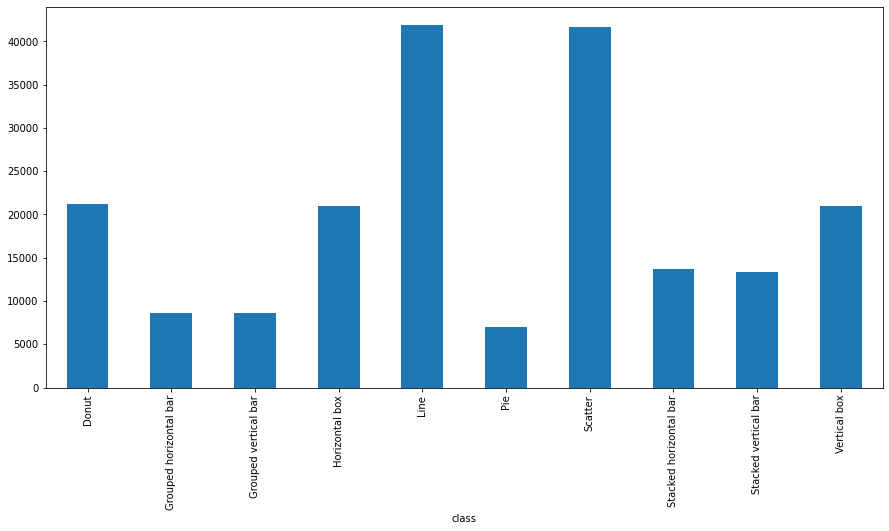

In [142]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['class']).count()['id'].plot.bar(ax=ax)

In [143]:
vert_boxes = df[df['class'] == 'Vertical box']

In [144]:
vert_boxes.head()

,id,class
6,148134,Vertical box
12,140647,Vertical box
30,142367,Vertical box
37,128359,Vertical box
63,147180,Vertical box


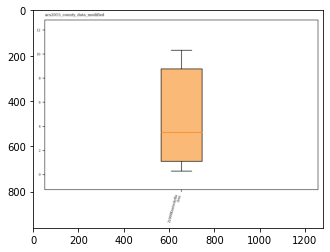

In [148]:
sample_vert_box = str(vert_boxes.iloc[10]['id']) + '.png'
img = mpimg.imread(IMAGES_DIR + sample_vert_box)
plt.imshow(img)

## Getting normalization values

In [54]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda:0")

def calc_dataset_mean_std(train_tensor_dataset, batch_size=32, num_workers=0):
    """
    Args:
        train_tensor_dataset: dataset with just a ToTensor transformation
          e.g. datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
    """    
    loader = DataLoader(train_tensor_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    mean = 0.0
    for images, _ in loader:
        images = images.to(device)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
            
    mean = mean / len(loader.dataset)
    
    var = 0.0
    sample_img, _ = train_tensor_dataset[0]
    # for std calculations
    h, w = sample_img.shape[1], sample_img.shape[2]
    
    for images, _ in loader:
        images = images.to(device)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])

    std = torch.sqrt(var / (len(loader.dataset)*w*h))
    
    return mean, std

In [1]:
from src.datapreprocessing import DataProprocessing
dp = DataProprocessing('/mnt/chart/raw/images', None, '/mnt/chart-classification/labels_task1.csv', seed=443)

In [2]:
train_dataset = dp.get_train_dataset(normalized=False)

In [19]:
len(train_dataset)

148507

In [5]:
len(validation_dataset)

49503

Grouped vertical bar


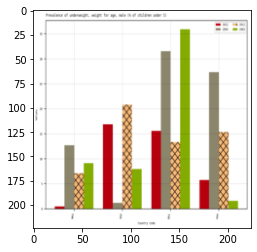

In [11]:
img_t, label = train_dataset[0]
print(label)
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [20]:
dp.train_keys

array([ 32942,  43790,  22220, ..., 182680,  49130, 157605])

In [9]:
dp.val_keys

array([111525, 128611,  55044, ...,  90377,  15877, 171055])

In [24]:
# np.intersect1d(dp.train_keys, dp.val_keys)
len(train_dataset)

148507

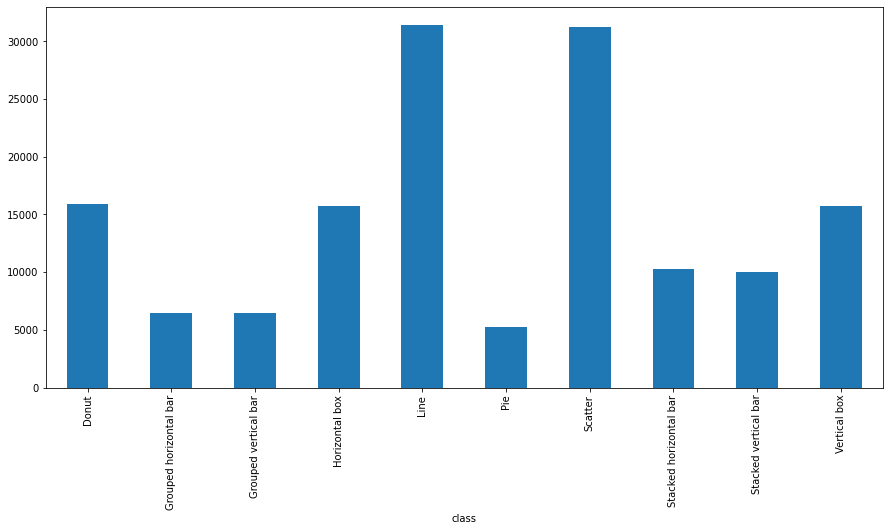

In [34]:
train_df = df[df['id'].isin(dp.train_keys)]
fig, ax = plt.subplots(figsize=(15,7))
train_df.groupby(['class']).count()['id'].plot.bar(ax=ax)

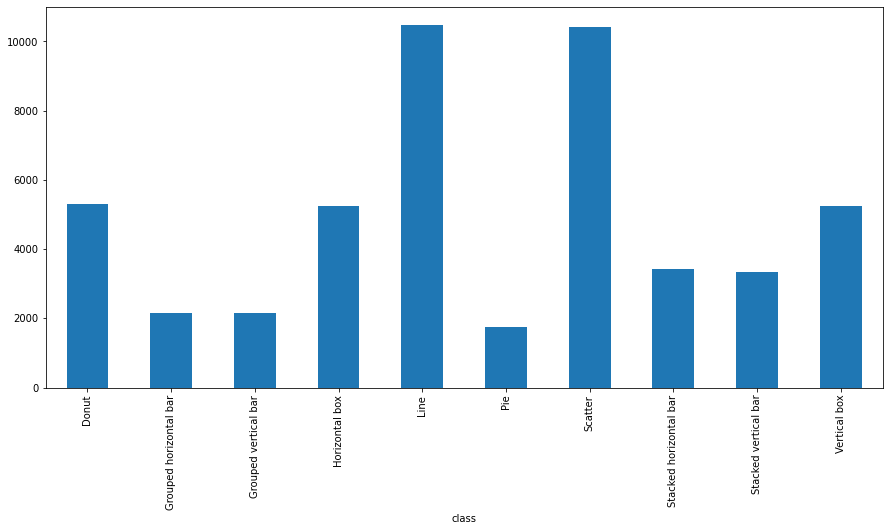

In [36]:
val_df = df[df['id'].isin(dp.val_keys)]
fig, ax = plt.subplots(figsize=(15,7))
val_df.groupby(['class']).count()['id'].plot.bar(ax=ax)

In [55]:
mean, std = calc_dataset_mean_std(train_dataset, batch_size=1024, num_workers=16)

In [56]:
mean

tensor([0.9257, 0.9208, 0.9217], device='cuda:0')

In [57]:
std

tensor([0.2079, 0.2000, 0.2135], device='cuda:0')

In [4]:
import torch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [5]:
device = torch.device("cuda:0")
for images, labels in train_loader:
    print(labels)
    images = images.to(device)
    labels = labels.to(device)
    
    break

tensor([6, 9, 2, 6, 0, 2, 0, 0, 1, 6, 7, 4, 3, 2, 7, 6, 3, 9, 0, 4, 4, 4, 4, 6,
        6, 9, 4, 4, 0, 4, 4, 6])


In [3]:
train_dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 2)